# Simple inversion demonstration


#### In this notebook we will demonstrate the process of inverting a single polarized spectrum with the goal of obtaining the parameters of the slab: magnetic field vector (Bx, By, Bz), optical depth, los and thermal velocity, and damping. We also have an option of fitting the ad-hoc beta parameter, that we will not use. We will also always assume filling factor is 1, i.e. we are not mixing multiple models for a single spectrum. 

#### Let's start by generating an example spectrum, and adding some noise to it. We will do it for different lines-of-sight and also for different strenghts of the magnetic field. That is, we will compare Zeeman and Hanle regime. 

#### Let's go! 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import hazel
import h5py

## We will start with a slab at the disk center, with strong magnetic field.

Text(0.5, 0, 'Wavelength')

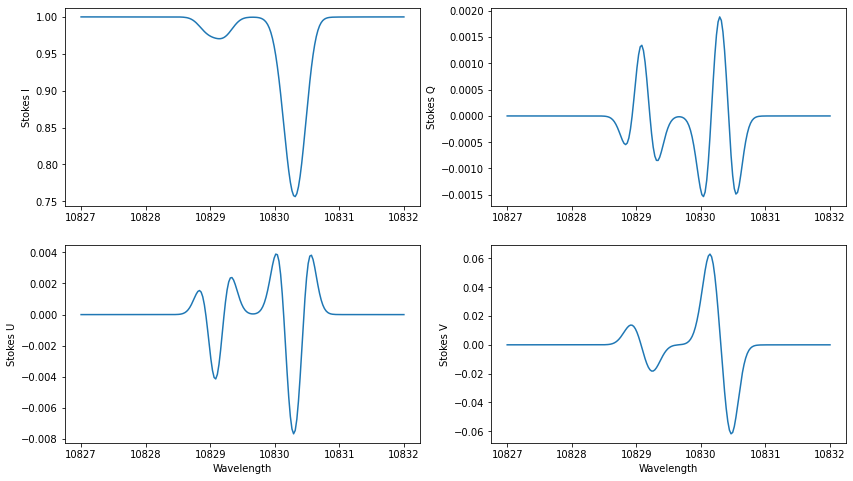

In [3]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10827, 10832, 200], 'topology': 'ch1',
    'LOS': [0.0,0.0,0.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 5.0, 'Line': '10830', 'Wavelength': [10827, 10832]})
mod.setup()

# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff. 
# Can you tell me which of the B components is los one, and which ones lie in the plane of the sky?
params_original = [500.0,700.0,1000.0,0.5,0.0,5.0,1.0,0.01]
mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = mod.spectrum['spec1'].wavelength_axis
n_wvl = len(ll)

plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

### Take a look at the values of polarization - how do they compare, with other lines we know of?

### Now, let's add some noise, and see how the data looks then. After that we will set-up the inversion!

In [5]:
noise_lvl = 1E-3

noise = np.random.normal(0,noise_lvl,4*200).reshape(4,200)
stokes = np.copy(mod.spectrum['spec1'].stokes) + noise

Text(0.5, 0, 'Wavelength')

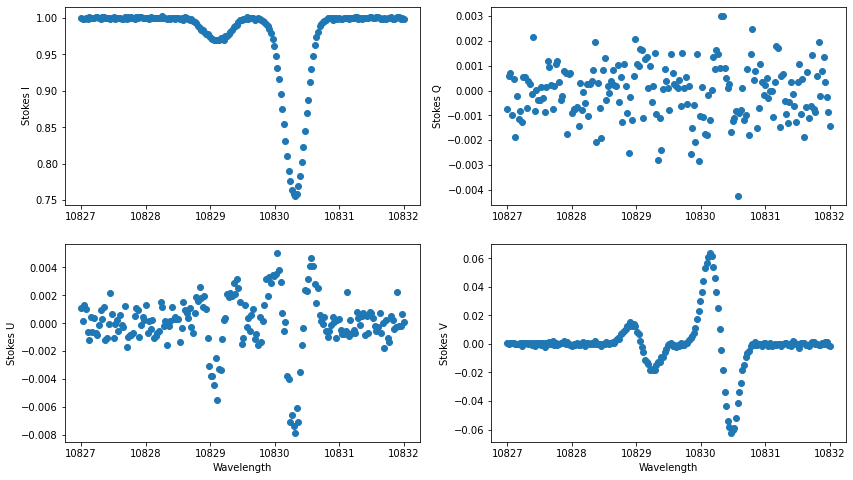

In [6]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

#### Now our next step is to store this data (spectra, noise, weigths, line-of-sight) in a way where a new hazel model, intended for inversion can read it, and hopefully give us some meaningful results. It would be ideal if we got back our original magnetic field that we put in! 

In [14]:
# First the wavelength axis
np.savetxt('10830_test.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

f = open('10830_test_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

### Take a look at the files you just made! 

. 

.

.

.

.

### Ok, the next step is to set-up an inversion. 

### To do that, you want to play with our config (i.e. 'ini') file. Let's do that in a separate editor.

.

.

.

.

.

### And after that you are ready for an inversion! 

In [17]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_zeeman.ini', working_mode='inversion', verbose=3, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-27 15:17:33,043 - Hazel2 v1.0
2022-01-27 15:17:33,044 - Using configuration from file : conf_zeeman.ini
2022-01-27 15:17:33,045 - Backtracking mode : brent
2022-01-27 15:17:33,045 - Adding spectral region spec1
2022-01-27 15:17:33,046 -   - Reading wavelength axis from 10830_test.wavelength
2022-01-27 15:17:33,047 -   - Reading wavelength weights from 10830_test.weights
2022-01-27 15:17:33,049 -   - Using observations from 10830_test_stokes.1d
2022-01-27 15:17:33,049 -   - No mask for pixels
2022-01-27 15:17:33,049 -   - No instrumental profile
2022-01-27 15:17:33,049 -   - Using LOS ['0.0', '0.0', '0.0']
2022-01-27 15:17:33,050 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2022-01-27 15:17:33,050 - Using 2 cycles
2022-01-27 15:17:33,050 - Using analytical RFs if possible : False
2022-01-27 15:17:33,051 - Using 20 max. iterations
2022-01-27 15:17:33,051 - Not using randomizations
2022-01-27 15:17:33,051 - Stopping when relative error is below 1e-05
2022-01-27 15:1

2022-01-27 15:17:39,728 - 
2022-01-27 15:17:39,728 - -----------
2022-01-27 15:17:39,729 - ch1
2022-01-27 15:17:39,729 - -----------
2022-01-27 15:17:39,729 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-27 15:17:39,729 - -924.055   924.408  1011.129     0.509     0.006     5.177     1.000     0.026
2022-01-27 15:17:39,729 - ==============================================================================
2022-01-27 15:17:39,730 - It: 1 - chi2:  16.130396 - lambda_opt:   0.011841 - rel:   0.837237
2022-01-27 15:17:39,730 - ==============================================================================
2022-01-27 15:17:40,516 - 
2022-01-27 15:17:40,516 - -----------
2022-01-27 15:17:40,516 - ch1
2022-01-27 15:17:40,517 - -----------
2022-01-27 15:17:40,517 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-27 15:17:40,517 - -214.308   355.166  1019.000     0.500     0.014     5.240     1.000     0.033
2022-01-27 15:

## Discuss the output a little bit. There is a lot to learn about the progress of our inversion just by looking at it!


### Now, let's analyze the results: 

In [18]:
# First, let's see if the spectrum fits at all! 
result = h5py.File('output_onepixel.h5','r')
result.keys()

<KeysViewHDF5 ['ch1', 'spec1']>

In [19]:
result['spec1'].keys()

<KeysViewHDF5 ['aic', 'bic', 'chi2', 'stokes', 'wavelength']>

In [20]:
result['ch1'].keys()

<KeysViewHDF5 ['B', 'B_err', 'B_nodes', 'Bx', 'Bx_err', 'Bx_nodes', 'By', 'By_err', 'By_nodes', 'Bz', 'Bz_err', 'Bz_nodes', 'a', 'a_err', 'a_nodes', 'beta', 'beta_err', 'beta_nodes', 'deltav', 'deltav_err', 'deltav_nodes', 'ff', 'ff_err', 'ff_nodes', 'phiB', 'phiB_err', 'phiB_nodes', 'tau', 'tau_err', 'tau_nodes', 'thB', 'thB_err', 'thB_nodes', 'v', 'v_err', 'v_nodes']>

In [21]:
fit = np.copy(result['spec1']['stokes'])
fit.shape

(1, 1, 4, 200)

In [22]:
fit = fit.reshape(1,4,200)
fit.shape

(1, 4, 200)

### Let's compare the fit with the 'observed' spectrum to see if our inversion did what it was supposed to do:

Text(0.5, 0, 'Wavelength')

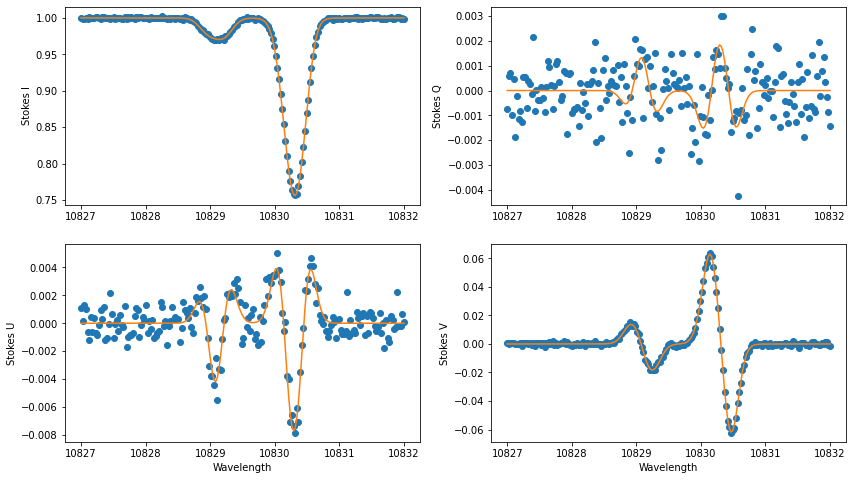

In [23]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.plot(ll,fit[0,0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[0,1,:])
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[0,2,:])
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[0,3,:])
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

## Let's see if we managed to recover the physical parameters:

In [24]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0], "Original = ", params_original[0])
print ("By= ",result['ch1']['By'][0,0,0], "Original = ", params_original[1])
print ("Bz= ",result['ch1']['Bz'][0,0,0], "Original = ", params_original[2])
print ("tau= ",result['ch1']['tau'][0,0,0], "Original = ", params_original[3])
print ("vlos ",result['ch1']['v'][0,0,0], "Original = ", params_original[4])
print ("vtherm= ",result['ch1']['deltav'][0,0,0], "Original = ", params_original[5])
print ("a= ",result['ch1']['a'][0,0,0], "Original = ", params_original[7])
result.close()

Bx=  503.1886692720309 Original =  500.0
By=  699.3193868802928 Original =  700.0
Bz=  997.5883193776467 Original =  1000.0
tau=  0.5010371567546822 Original =  0.5
vlos  0.008027998551838778 Original =  0.0
vtherm=  4.987816874061391 Original =  5.0
a=  0.012281458180596987 Original =  0.01


## 1) The parameters are very close to the original ones. Go back now and increase the amount of 'noise' in our data. What happens to the inferred parameters?
.
.
.

## 2) If you were (un)lucky, you might have gotten a 'flipped' solution for Bx,By. Why is this so? Is this the error of the code or something else? If you did not get the flipped solution, go change the starting parameters in your chromosphere.1d file to get it.

.
.
.
## 3) For those of you who want an additional (homework) problem. Go back and set the code to fit only Stokes I, using thermodynamic parameters in first cycle, and only Q,U and V in the second cycle. Can you recover input parameters? Why?


.

.

.


## Now something completely different: A slab at the limb, with very weak magnetic field!

### What should the LOS be? What are the boundary conditions? 

### What physics do you expect? How strong polarization do you expect?

Text(0.5, 0, 'Wavelength')

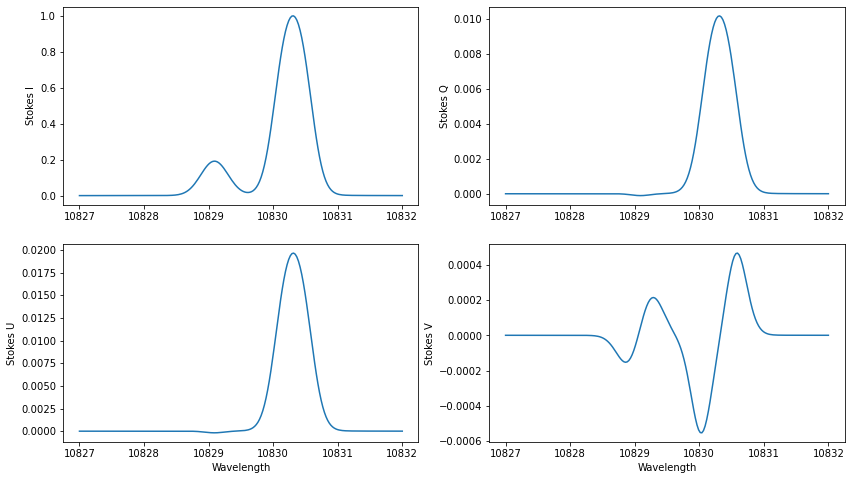

In [166]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10827, 10832, 200], 'topology': 'ch1',
    'LOS': [90.0,0.0,90.0], 'Boundary condition': [0.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10827, 10832]})
mod.setup()
# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff
params_original = [3.0,-4.0,7.0,1.0,0.0,8.0,1.0,0.01]
mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = mod.spectrum['spec1'].wavelength_axis
n_wvl = len(ll)

plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

#### Note that in this case, Stokes V is very weak. We will set a very low noise as well, to be able to fit it, but generally expect noisy spectra in this case! 

In [167]:
# Generate random noise of a given amplitude.
noise_lvl = 1E-6

random_noise = np.random.normal(0,noise_lvl,4*200)
random_noise = random_noise.reshape(4,200)
stokes = np.copy(mod.spectrum['spec1'].stokes) + random_noise

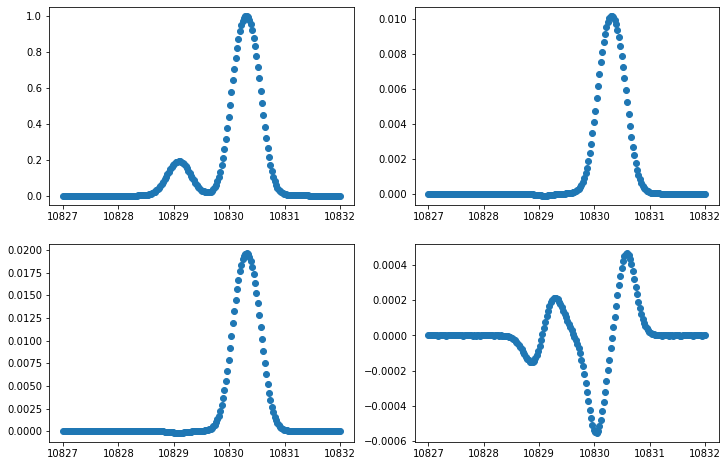

In [168]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')

In [169]:
# First the wavelength axis
np.savetxt('10830_test.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

stokes = np.copy(mod.spectrum['spec1'].stokes) + random_noise # already defined above, but repeated for safety

f = open('10830_test_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

In [170]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test.ini', working_mode='inversion', verbose=3, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-27 14:01:24,693 - Hazel2 v1.0
2022-01-27 14:01:24,701 - Using configuration from file : conf_test.ini
2022-01-27 14:01:24,714 - Backtracking mode : brent
2022-01-27 14:01:24,730 - Adding spectral region spec1
2022-01-27 14:01:24,754 -   - Reading wavelength axis from 10830_test.wavelength
2022-01-27 14:01:24,785 -   - Reading wavelength weights from 10830_test.weights
2022-01-27 14:01:24,801 -   - Using observations from 10830_test_stokes.1d
2022-01-27 14:01:24,846 -   - No mask for pixels
2022-01-27 14:01:24,848 -   - No instrumental profile
2022-01-27 14:01:24,853 -   - Using LOS ['90.00', '0.0', '90.0']
2022-01-27 14:01:24,854 -   - Using off-limb normalization (peak intensity)
2022-01-27 14:01:24,873 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2022-01-27 14:01:24,877 - Using 3 cycles
2022-01-27 14:01:24,894 - Using analytical RFs if possible : False
2022-01-27 14:01:24,897 - Using 10 max. iterations
2022-01-27 14:01:24,911 - Not using randomizations
2022-01-

2022-01-27 14:01:37,563 -    6.846   -12.459    20.291     0.969     0.001     8.057     1.000     0.006
2022-01-27 14:01:37,564 - ==============================================================================
2022-01-27 14:01:37,567 - It: 4 - chi2: 27582.161228 - lambda_opt:   0.003313 - rel:   1.810609
2022-01-27 14:01:37,572 - ==============================================================================
2022-01-27 14:01:38,756 - 
2022-01-27 14:01:38,757 - -----------
2022-01-27 14:01:38,758 - ch1
2022-01-27 14:01:38,760 - -----------
2022-01-27 14:01:38,762 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-27 14:01:38,763 -    6.722   -10.222    17.362     0.969     0.001     8.057     1.000     0.006
2022-01-27 14:01:38,769 - ==============================================================================
2022-01-27 14:01:38,772 - It: 5 - chi2: 13376.110436 - lambda_opt:   0.002314 - rel:   0.693684
2022-01-27 14:01:38,773 - =====================

## Discuss the output a little bit. There is a lot to learn about the progress of our inversion just by looking at it!

### Now, let's analyze the results: 

In [171]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(1,4,200)

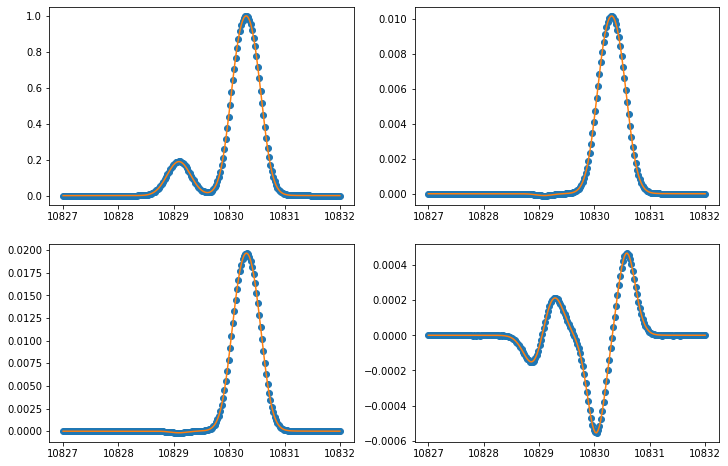

In [172]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.plot(ll,fit[0,0,:])
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[0,1,:])
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[0,2,:])
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[0,3,:])

In [173]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0], "Original = ", params_original[0])
print ("By= ",result['ch1']['By'][0,0,0], "Original = ", params_original[1])
print ("Bz= ",result['ch1']['Bz'][0,0,0], "Original = ", params_original[2])
print ("tau= ",result['ch1']['tau'][0,0,0], "Original = ", params_original[3])
print ("vlos ",result['ch1']['v'][0,0,0], "Original = ", params_original[4])
print ("vtherm= ",result['ch1']['deltav'][0,0,0], "Original = ", params_original[5])
print ("a= ",result['ch1']['a'][0,0,0], "Original = ", params_original[7])
result.close()

Bx=  3.0128455546188846 Original =  3.0
By=  -4.036388019273623 Original =  -4.0
Bz=  7.0585398108757005 Original =  7.0
tau=  0.968537575314288 Original =  1.0
vlos  0.0005124931747246819 Original =  0.0
vtherm=  8.0573013250495 Original =  8.0
a=  0.006440418436283017 Original =  0.01


### Repeat the exercise with a larger amount of noise and see how it changes!

.

.

.


.

## A very important point: Increasing the level of noise, *very quickly* destroys the information about the magnitude of the magnetic field, but the orientation stays more or less similar. Why is this so?

.

.

.

.

# Ambiguity.

### The code can find multiple solutions that are mathematically completely identical! To reproduce that, let's perform multiple inversions with slightly different intial conditions. Hazel 2 can do that for us automatically, by changing the number of randomizations. Let's also shake things up and perform on-disk inversions. 


### We will also slightly condense our setup.

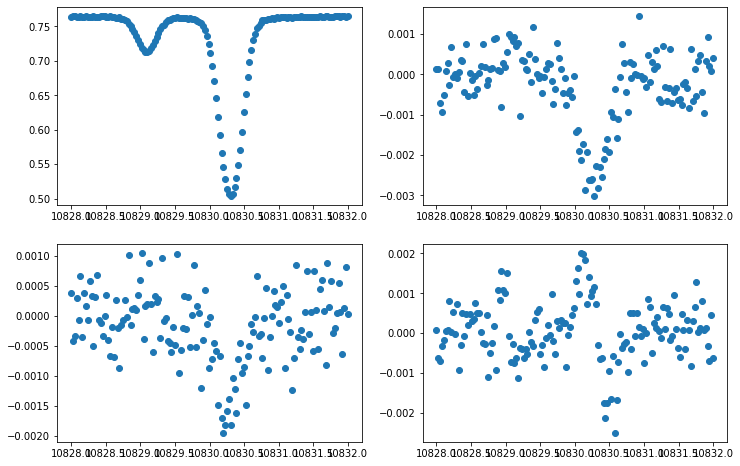

In [26]:
del(mod)
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10828, 10832, 150], 'topology': 'ch1',
    'LOS': [70.0,0.0,0.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10828, 10832]})
mod.setup()
# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff
params_original = [20.0,50.0,20.0,1.0,0.0,5.0,1.0,0.1]
mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = mod.spectrum['spec1'].wavelength_axis
n_wvl = len(ll)

# Generate random noise of a given amplitude.
noise_lvl = 5E-4
random_noise = np.random.normal(0,noise_lvl,4*150)
random_noise = random_noise.reshape(4,150)

mod.spectrum['spec1'].stokes += random_noise # condensed the addition of noise in 1 line

plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:],'o')
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:],'o')
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:],'o')
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:],'o')

In [27]:
# First the wavelength axis
np.savetxt('10830_test.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

stokes = np.copy(mod.spectrum['spec1'].stokes)

f = open('10830_test_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'70.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

In [28]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_ondisk.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=3)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-27 15:22:55,784 - Hazel2 v1.0
2022-01-27 15:22:55,785 - Using configuration from file : conf_test_ondisk.ini
2022-01-27 15:22:55,787 - Backtracking mode : brent
2022-01-27 15:22:55,788 - Adding spectral region spec1
2022-01-27 15:22:55,788 -   - Reading wavelength axis from 10830_test.wavelength
2022-01-27 15:22:55,790 -   - Reading wavelength weights from 10830_test.weights
2022-01-27 15:22:55,791 -   - Using observations from 10830_test_stokes.1d
2022-01-27 15:22:55,792 -   - No mask for pixels
2022-01-27 15:22:55,792 -   - No instrumental profile
2022-01-27 15:22:55,793 -   - Using LOS ['70.00', '0.0', '0.0']
2022-01-27 15:22:55,793 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2022-01-27 15:22:55,794 - Using 2 cycles
2022-01-27 15:22:55,794 - Using analytical RFs if possible : False
2022-01-27 15:22:55,794 - Using 10 max. iterations
2022-01-27 15:22:55,795 - Not using randomizations
2022-01-27 15:22:55,795 - Saving all cycles : False
2022-01-27 15:22:55,795 - 

In [29]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(4,150)

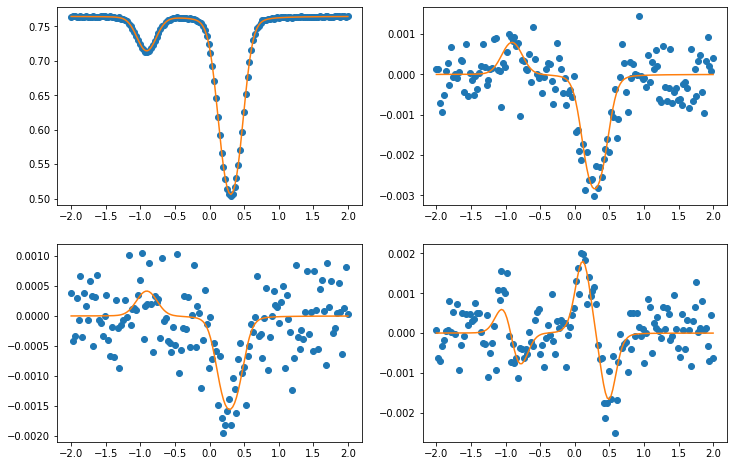

In [30]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll-10830,stokes[0,:],'o')
plt.plot(ll-10830,fit[0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes[1,:],'o')
plt.plot(ll-10830,fit[1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes[2,:],'o')
plt.plot(ll-10830,fit[2,:])
plt.subplot(224)
plt.plot(ll-10830,stokes[3,:],'o')
plt.plot(ll-10830,fit[3,:])

In [31]:
result['ch1'].keys()
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0], "Original = ", params_original[0])
print ("By= ",result['ch1']['By'][0,0,0], "Original = ", params_original[1])
print ("Bz= ",result['ch1']['Bz'][0,0,0], "Original = ", params_original[2])
print ("tau= ",result['ch1']['tau'][0,0,0], "Original = ", params_original[3])
print ("vlos ",result['ch1']['v'][0,0,0], "Original = ", params_original[4])
print ("vtherm= ",result['ch1']['deltav'][0,0,0], "Original = ", params_original[5])
print ("a= ",result['ch1']['a'][0,0,0], "Original = ", params_original[7])

Bx=  51.0784030426762 Original =  20.0
By=  17.594166595541424 Original =  50.0
Bz=  -57.496478487974514 Original =  20.0
tau=  0.9832910888390847 Original =  1.0
vlos  0.0025709483236013853 Original =  0.0
vtherm=  5.002043255790866 Original =  5.0
a=  0.10203828511338406 Original =  0.1


## WOW! The values are completely different (and the amount of noise does not influence that!). Let's confirm that this is indeed the case and we did not make any mistake! :-) 

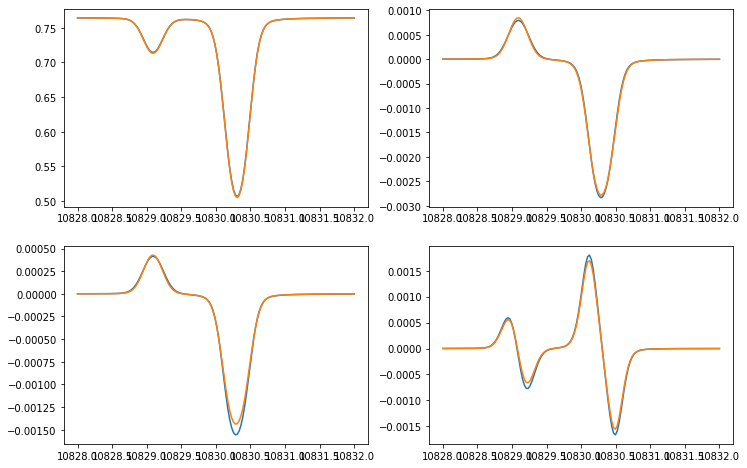

In [32]:
mod_test = hazel.Model(working_mode='synthesis')
mod_test.add_spectral({'Name': 'spec1', 'Wavelength': [10828, 10832, 150], 'topology': 'ch1',
    'LOS': [70.0,0.0,0.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})
mod_test.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10828, 10832]})
mod_test.setup()
# Vector of parameters are (Bx,By,Bztau,v,deltav,beta,a) and then the ff
params_test = [result['ch1']['Bx'][0,0,0],result['ch1']['By'][0,0,0],result['ch1']['Bz'][0,0,0],result['ch1']['tau'][0,0,0] /
              result['ch1']['v'][0,0,0],result['ch1']['deltav'][0,0,0],1.0,result['ch1']['a'][0,0,0]]
mod_test.atmospheres['ch1'].set_parameters(params_original,1.0)
mod_test.synthesize()

plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.plot(ll,mod_test.spectrum['spec1'].stokes[0,:])
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.plot(ll,mod_test.spectrum['spec1'].stokes[1,:])
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.plot(ll,mod_test.spectrum['spec1'].stokes[2,:])
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])
plt.plot(ll,mod_test.spectrum['spec1'].stokes[3,:])

### Try to change starting values in the model file to see if this will change.

. 

. 

. 

#### Lot to discuss here? Is this noise induced or real degeneracy? Where is the ambiguity.... 

51.0784030426762 17.594166595541424 -57.496478487974514


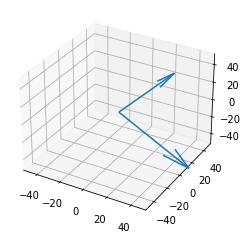

In [33]:
from mpl_toolkits.mplot3d import Axes3D
Bx = result['ch1']['Bx'][0,0,0]
By = result['ch1']['By'][0,0,0]
Bz = result['ch1']['Bz'][0,0,0]
print (Bx,By,Bz)
vectors = np.array([[0, 0, 0, params_original[0],params_original[1],params_original[2]], [0, 0, 0, Bx,By,Bz]])
                                                                                        
X, Y, Z, U, V, W = zip(*vectors)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
plt.show()

# Extra content, if the time allows! 

## (If not, check this out on your own, if you plan to inver He 10830 observations on your own!

## We can repeat the previous exercise using multiple 'randomizations'. That is, the code will now start from somewhat different starting values of the parameters and (we hope), end up in different , equally plausible, final solutions. Let's give that a go!

In [75]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_ondisk.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=10)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-27 15:45:39,661 - Hazel2 v1.0
2022-01-27 15:45:39,661 - Using configuration from file : conf_test_ondisk.ini
2022-01-27 15:45:39,663 - Backtracking mode : brent
2022-01-27 15:45:39,663 - Adding spectral region spec1
2022-01-27 15:45:39,663 -   - Reading wavelength axis from 10830_test.wavelength
2022-01-27 15:45:39,665 -   - Reading wavelength weights from 10830_test.weights
2022-01-27 15:45:39,666 -   - Using observations from 10830_test_stokes.1d
2022-01-27 15:45:39,666 -   - No mask for pixels
2022-01-27 15:45:39,667 -   - No instrumental profile
2022-01-27 15:45:39,667 -   - Using LOS ['70.00', '0.0', '0.0']
2022-01-27 15:45:39,667 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2022-01-27 15:45:39,668 - Using 2 cycles
2022-01-27 15:45:39,668 - Using analytical RFs if possible : False
2022-01-27 15:45:39,668 - Using 10 max. iterations
2022-01-27 15:45:39,668 - Using a maximum of 10 randomizations
2022-01-27 15:45:39,669 - Stopping when relative error is below 1e

In [76]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit.shape

(1, 10, 4, 150)

In [77]:
result['spec1']['chi2'][0]

array([[0.70557484, 0.70557484],
       [0.70652087, 0.70652087],
       [0.70557422, 0.70557422],
       [1.49467656, 1.49467656],
       [0.70428921, 0.70428921],
       [0.7065207 , 0.7065207 ],
       [0.704289  , 0.704289  ],
       [0.85636344, 0.85636344],
       [0.70428886, 0.70428886],
       [0.70652035, 0.70652035]])

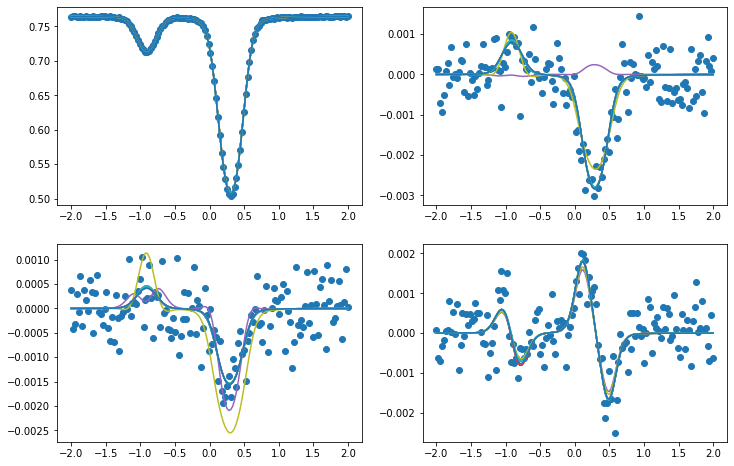

In [78]:
# Second index stands for the number of randomizations! Now let's plot all 5 and compare with the "observations":
nrand = 10
fit = fit.reshape(nrand,4,150)


plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll-10830,stokes[0,:],'o')
for i in range(0,nrand):
    plt.plot(ll-10830,fit[i,0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes[1,:],'o')
for i in range(0,nrand):
    plt.plot(ll-10830,fit[i,1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes[2,:],'o')
for i in range(0,nrand):
    plt.plot(ll-10830,fit[i,2,:])
plt.subplot(224)
plt.plot(ll-10830,stokes[3,:],'o')
for i in range(0,nrand):
    plt.plot(ll-10830,fit[i,3,:])

In [79]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,:,0], "Original = ", params_original[0])
print ("By= ",result['ch1']['By'][0,:,0], "Original = ", params_original[1])
print ("Bz= ",result['ch1']['Bz'][0,:,0], "Original = ", params_original[2])
print ("tau= ",result['ch1']['tau'][0,:,0], "Original = ", params_original[3])
print ("vlos ",result['ch1']['v'][0,:,0], "Original = ", params_original[4])
print ("vtherm= ",result['ch1']['deltav'][0,:,0], "Original = ", params_original[5])
print ("a= ",result['ch1']['a'][0,:,0], "Original = ", params_original[7])
result.close()

Bx=  [ 18.68620033  51.07217486  18.68628628 -26.39853741  21.04702264
  51.07361619  21.04668737  58.02689846  21.04675975  51.068115  ] Original =  20.0
By=  [  -5.77916265   17.59144178   -5.77937484 -164.44337393   61.07454379
   17.59238834   61.09900464 -225.26326945   61.10894344   17.5897755 ] Original =  50.0
Bz=  [ 32.12398583 -57.48867762  32.12419951 145.40489525  24.20880718
 -57.49050616  24.21859428 -84.56960099  24.22251545 -57.48373149] Original =  20.0
tau=  [0.9832856  0.98328856 0.98329282 0.98329189 0.98329007 0.9832906
 0.98328989 0.98329138 0.98329144 0.98329296] Original =  1.0
vlos  [0.00260652 0.00259069 0.00260559 0.00257136 0.00259574 0.00256934
 0.0025642  0.00263433 0.00255813 0.00256237] Original =  0.0
vtherm=  [5.00213005 5.00211091 5.00200126 5.00201568 5.00211677 5.00205571
 5.00207017 5.00217621 5.0020331  5.00198865] Original =  5.0
a=  [0.10202344 0.10202501 0.10204585 0.10204386 0.10202155 0.10203529
 0.10203312 0.10199942 0.10204022 0.10204928] O